In [5]:
#!g1.1

import torch
device = 'cuda'

torch.cuda.is_available()

True

## База (основа)


In [6]:
#!g1.1

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from PIL import Image
from IPython.display import clear_output

sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 12})

## Загрузка датасетов

In [7]:
from google.colab import files
uploaded = files.upload()

Saving bhw-1-dl-2024-2025.zip to bhw-1-dl-2024-2025.zip


In [8]:
import zipfile
import os

with zipfile.ZipFile("bhw-1-dl-2024-2025.zip", "r") as zip_ref:
    zip_ref.extractall("/content/bhw")

os.listdir("/content/bhw")

['bhw1']

In [9]:
#!g1.1

class ImageDataset(Dataset):
    # TRAIN_PATH = '/kaggle/input/bhw-1-dl-2024-2025/bhw1/trainval'
    # LABEL_PATH = '/kaggle/input/bhw-1-dl-2024-2025/bhw1/labels.csv'
    # TEST_PATH = '/kaggle/input/bhw-1-dl-2024-2025/bhw1/test'
    TRAIN_PATH = '/content/bhw/bhw1/trainval'
    LABEL_PATH = '/content/bhw/bhw1/labels.csv'
    TEST_PATH = '/content/bhw/bhw1/test'

    def __init__(self, train=True, transform=None):
        super().__init__()
        self.train = train
        self.transform = transform
        self.dir_name = self.TRAIN_PATH if train else self.TEST_PATH
        self.images, self.labels = self.load_images(self.dir_name)

    def load_images(self, dir_name):
        images = sorted(os.listdir(dir_name))
        labels = []
        if self.train:
            image_labels = pd.read_csv(self.LABEL_PATH)
            labels = image_labels.sort_values(by='Id')['Category'].tolist()
        return images, labels

    def set_transform(self, transform):
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, item):
        image = Image.open(os.path.join(self.dir_name, self.images[item])).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        label = self.images[item]
        if self.train:
            label = self.labels[item]
        return image, label


In [10]:
#!g1.1

def split_data(data):
    data_size = len(data)
    val_size = int(data_size * 0.2)
    return torch.utils.data.random_split(data, [data_size - val_size, val_size],
                                         generator=torch.Generator().manual_seed(777))

## Визуализация метрик

In [11]:
#!g1.1

def visualize_process(train_losses, val_losses, train_accuracies, val_accuracies):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(val_losses) + 1), val_losses, label='validation')
    axs[0].set_ylabel('loss')
    axs[0].set_xlabel('epoch')
    axs[0].legend()

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(val_accuracies) + 1), val_accuracies, label='validation')
    axs[1].set_ylabel('accuracy')
    axs[1].set_xlabel('epoch')
    axs[1].legend()

    plt.show()


## Обучение и тестирование

In [12]:
#!g1.1

def train_epoch(train_loader, model, optimizer, criterion):
    loss_sum, acc_sum = 0.0, 0.0
    model.train()
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # standard training process
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        # compute accuracy
        _, pred = output.max(dim=1)
        acc = (pred == labels).sum()
        # log metrics
        loss_sum += loss.item()
        acc_sum += acc.item()

    return loss_sum / len(train_loader.dataset), acc_sum / len(train_loader.dataset)


def validate_epoch(val_loader, model, criterion):
    loss_sum, acc_sum = 0.0, 0.0
    model.eval()
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        # evaluate model
        output = model(images)
        # compute loss
        loss = criterion(output, labels)
        # compute accuracy
        _, pred = output.max(dim=1)
        acc = (pred == labels).sum()
        # log metrics
        loss_sum += loss.item()
        acc_sum += acc.item()

    return loss_sum / len(val_loader.dataset), acc_sum / len(val_loader.dataset)


def train_model(model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs, debug=False):
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train_epoch(train_loader, model, optimizer, criterion)
        val_loss, val_accuracy = validate_epoch(val_loader, model, criterion)

        # change learning rate
        if scheduler is not None:
            scheduler.step()
        # log metrics
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        if debug:
            print(f"Epoch {epoch}")
            print(f" train loss: {train_loss}, train acc: {train_accuracy}")
            print(f" val loss: {val_loss}, val acc: {val_accuracy}\n")

    visualize_process(train_losses, val_losses, train_accuracies, val_accuracies)
    return train_losses, val_losses, train_accuracies, val_accuracies


## Получение предсказания

In [13]:
#!g1.1

def predict(test_loader, model):
    model.eval()
    predictions, image_names = [], []
    for images, names in test_loader:
        images = images.to(device)
        # evaluate model
        output = model(images)
        # get prediction
        _, pred = output.max(dim=1)
        predictions.extend(pred.tolist())
        # get name
        image_names.extend(names)

    return pd.DataFrame(data={'Id': image_names, 'Category': predictions})

## Сохранение и загрузка модели

In [14]:
#!g1.1

def save_state(model, optimizer, filename='model.pth.tar'):
    state = {
        'model_dict': model.state_dict(),
        'optimizer_dict': optimizer.state_dict()
    }
    torch.save(state, filename)

def load_state(model, optimizer, filename='model.pth.tar'):
    state = torch.load(filename)
    if model is not None:
        model.load_state_dict(state['model_dict'])
    if optimizer is not None:
        optimizer.load_state_dict(state['optimizer_dict'])

## Изучение данных

In [15]:
#!g1.1

train_data = ImageDataset()
test_data = ImageDataset(train=False)

In [16]:
#!g1.1

image, label = train_data[0]
image.size

(40, 40)

In [17]:
#!g1.1

labels = pd.read_csv('/content/bhw/bhw1/labels.csv')
len(labels)

100000

## Начало экспериментов

Поделим тренировочну выборку на тренировочную и валидационную

In [18]:
#!g1.1

train, val = split_data(train_data)
train_loader = DataLoader(train, batch_size=64, shuffle=True)
val_loader = DataLoader(val, batch_size=64, shuffle=True)

## Усложнённая архитектура

In [19]:
#!g1.1

class MyLittleResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False, dropout=0.0):
        super().__init__()

        # init main modules
        self.conv_1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                kernel_size=3, stride=1 if not downsample else 2, padding=1, bias=False)
        self.conv_2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels,
                                kernel_size=3, stride=1, padding=1, bias=False)
        self.bn_1 = nn.BatchNorm2d(num_features=out_channels)
        self.bn_2 = nn.BatchNorm2d(num_features=out_channels)

        # init activations
        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU(inplace=True)

        # init shortcut
        self.shortcut = None if not downsample else \
            nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                          kernel_size=1, stride=2, padding=0, bias=False),
                nn.BatchNorm2d(num_features=out_channels)
            )

    def forward(self, x):
        shortcut = x if self.shortcut is None else self.shortcut(x)
        out = self.dropout(self.relu(self.bn_1(self.conv_1(x))))
        out = self.dropout(self.relu(self.bn_2(self.conv_2(out))))
        out = out + shortcut
        out = self.dropout(self.relu(out))
        return out


class MyLittleNet(nn.Module):
    def __init__(self, in_channels, basic_block, dropout=0.0):
        super().__init__()

        # create stem block
        self.stem = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=64,
                      kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU()
        )

        # create basic blocks
        self.layer_1 = nn.Sequential(
            basic_block(in_channels=64, out_channels=64, downsample=False, dropout=dropout),
            basic_block(in_channels=64, out_channels=64, downsample=False, dropout=dropout)
        )
        self.layer_2 = nn.Sequential(
            basic_block(in_channels=64, out_channels=128, downsample=True, dropout=dropout),
            basic_block(in_channels=128, out_channels=128, downsample=False, dropout=dropout)
        )
        self.layer_3 = nn.Sequential(
            basic_block(in_channels=128, out_channels=256, downsample=True, dropout=dropout),
            basic_block(in_channels=256, out_channels=256, downsample=False, dropout=dropout)
        )
        self.layer_4 = nn.Sequential(
            basic_block(in_channels=256, out_channels=512, downsample=True, dropout=dropout),
            basic_block(in_channels=512, out_channels=512, downsample=False, dropout=dropout)
        )

        # modules for fully connected layer
        self.avgpool = torch.nn.AdaptiveAvgPool2d(output_size=1)
        self.linear = torch.nn.Linear(in_features=512, out_features=200)

    def forward(self, x):
        # stem layer
        out = self.stem(x)
        # basic block layers
        out = self.layer_1(out)
        out = self.layer_2(out)
        out = self.layer_3(out)
        out = self.layer_4(out)
        # fully connected layer
        out = self.avgpool(out)
        out = torch.flatten(out, start_dim=1)
        out = self.linear(out)
        # result
        return out


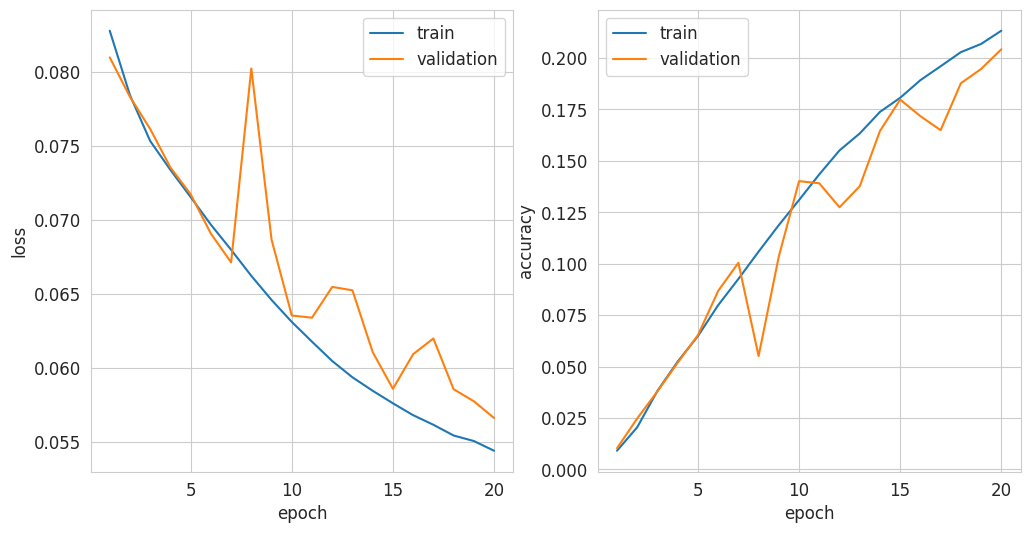

In [20]:
#!g1.1

train_data.transform = T.ToTensor()

model = MyLittleNet(in_channels=3, basic_block=MyLittleResidualBlock, dropout=0.5).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.95 ** epoch)

num_epochs = 20
train_losses, test_losses, train_accuracies, test_accuracies = train_model(
    model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs, debug=True
)

In [21]:
#!g1.1

save_state(model, optimizer)

Дообучаем модель ещё такими же 20 эпохами, потому что переобучается она не сильно и, кажется, можно получить ещё прирост в качестве

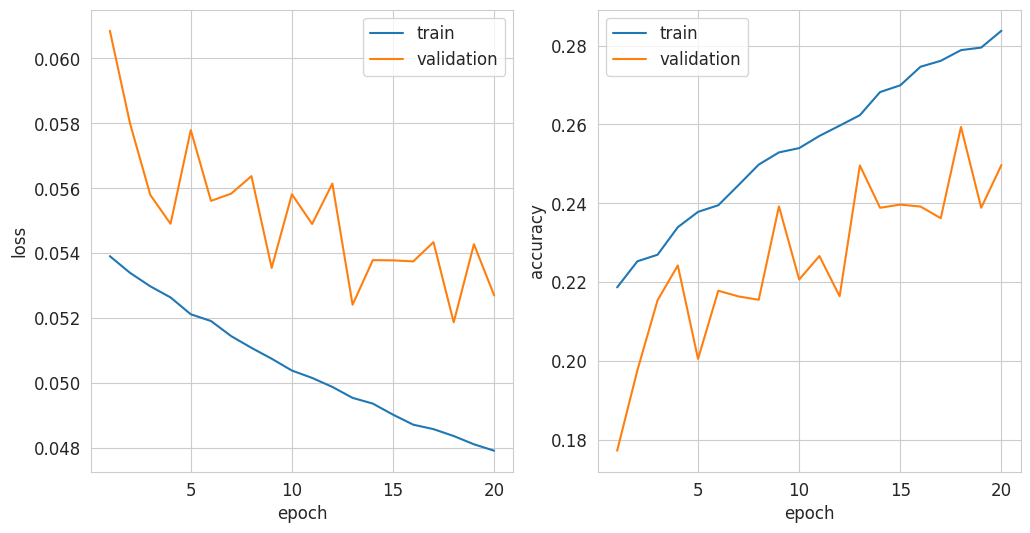

In [22]:
#!g1.1

num_epochs = 20
train_losses, test_losses, train_accuracies, test_accuracies = train_model(
    model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs, debug=True
)

In [23]:
#!g1.1

save_state(model, optimizer, 'newmodel.pth.tar')

**Вывод**

На валидации качество улучшилось, но не особо. Попробуем теперь дообучить модель в других условиях

In [24]:
#!g1.1

train_transform = T.Compose([
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
train_data.transform = train_transform


train, val = split_data(train_data)
train_loader = DataLoader(train, batch_size=64, shuffle=True)
val_loader = DataLoader(val, batch_size=64, shuffle=True)

In [25]:
#!g1.1
optimizer.param_groups[0]['lr'] = 1

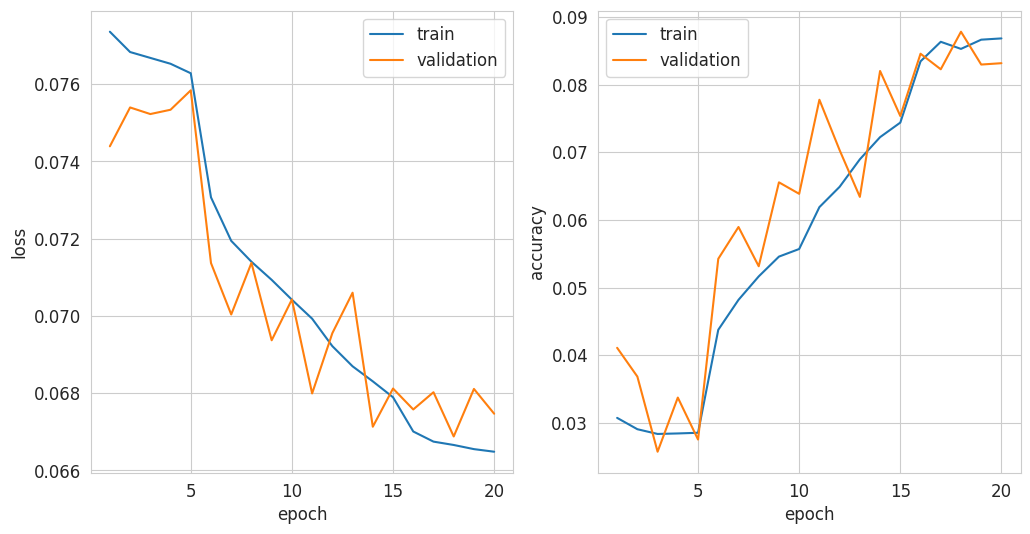

In [26]:
#!g1.1

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 15], gamma=0.1)

num_epochs = 20
train_losses, test_losses, train_accuracies, test_accuracies = train_model(
    model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs, debug=True
)

In [27]:
#!g1.1

save_state(model, optimizer, 'augmentationsmodel.pth.tar')

**Выводы**

С аугментацией данных переобучение устраняется, но предобученность модели не сильно помогает, поэтому обучем всю модель заново на 40 эпох с MultiStepLR и аугментациями данных. Также сделаю Dropout поменьше, чтобы ускорить обучение

## Аугментация

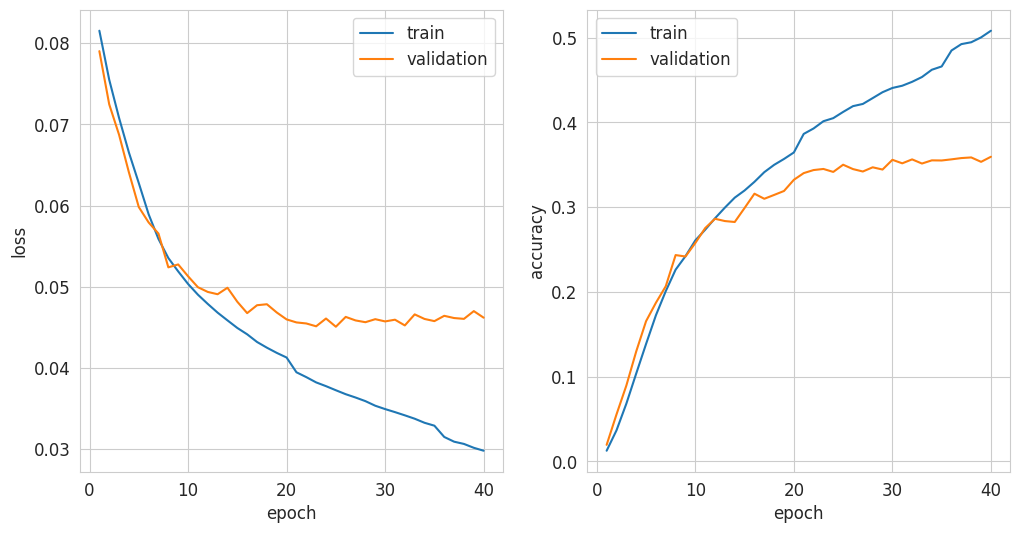

In [28]:
#!g1.1

train_transform = T.Compose([
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
train_data.transform = train_transform

model = MyLittleNet(in_channels=3, basic_block=MyLittleResidualBlock, dropout=0.3).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 35], gamma=0.8)

train, val = split_data(train_data)
train_loader = DataLoader(train, batch_size=64, shuffle=True)
val_loader = DataLoader(val, batch_size=64, shuffle=True)

num_epochs = 40
train_losses, test_losses, train_accuracies, test_accuracies = train_model(
    model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs, debug=True
)

In [29]:
#!g1.1

save_state(model, optimizer, 'newaugmodel.pth.tar')

## Продолжение экспериментов

Модель снова переобучается, поэтому попробую обучаться на 20 эпох с другой аугментацией + подставлю свои коэффы нормализации вместо предлагаемых

In [30]:
# !g1.1 закомментить
train_data.transform = T.ToTensor()
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

batches = len(train_loader)
means = torch.zeros(3).to(device)
stds = torch.zeros(3).to(device)
for images, labels in train_loader:
    images = images.to(device)
    mean, std = images.mean([0, 2, 3]), images.std([0, 2, 3])

    means += mean
    stds += std

print(means / batches, stds / batches)

tensor([0.5692, 0.5447, 0.4933], device='cuda:0') tensor([0.2378, 0.2328, 0.2507], device='cuda:0')


In [31]:
# #!g1.1
# закомментить
model = MyLittleNet(in_channels=3, basic_block=MyLittleResidualBlock, dropout=0.3).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15], gamma=0.5)

load_state(model, optimizer, filename='newaugmodel.pth.tar')

<ipython-input-14-b9bb4043d9ce>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(filename)


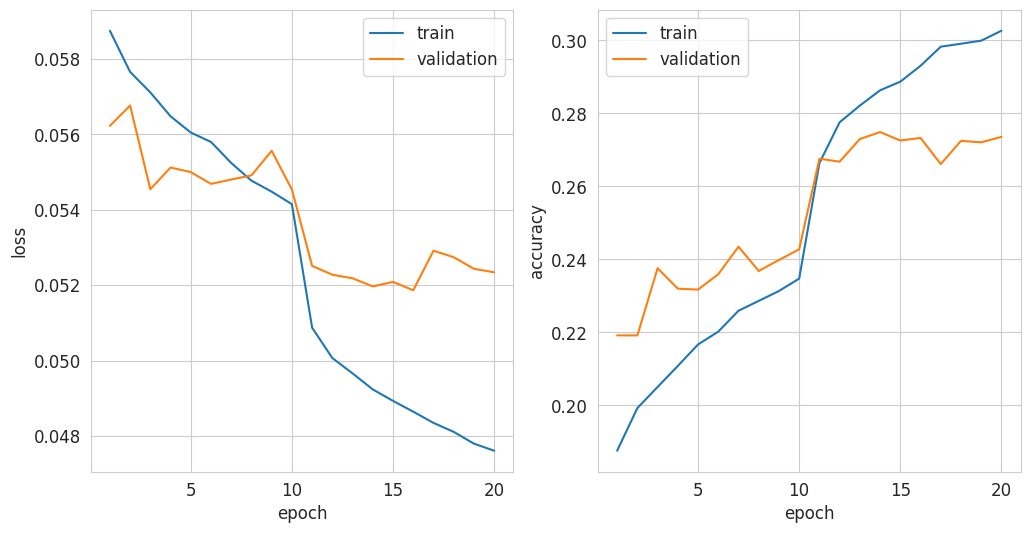

In [36]:
#!g1.1

train_transform = T.Compose([
    T.Resize(80),
    T.CenterCrop(40),
    T.ToTensor(),
    T.Normalize(mean=[0.5692, 0.5447, 0.4933], std=[0.2378, 0.2327, 0.2507]),
])
train_data.transform = train_transform

train, val = split_data(train_data)
train_loader = DataLoader(train, batch_size=64, shuffle=True)
val_loader = DataLoader(val, batch_size=64, shuffle=True)

num_epochs = 20
train_losses, test_losses, train_accuracies, test_accuracies = train_model(
    model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs, debug=True
)

In [37]:
#!g1.1

save_state(model, optimizer, 'newtransform.pth.tar')

## Fine Tuning

Во всех эксперементах модель переобучалась, попробуем приделать модели другую голову, которая будет выступать регуляризатором.

Попробуем поменять последний линейный слой на вот это

`nn.Sequential(
    nn.BatchNorm1d(num_features=512),
    nn.Dropout(p=0.25),
    nn.Linear(in_features=512, out_features=512),
    nn.ReLU(),
    nn.BatchNorm1d(num_features=512, eps=1e-05, momentum=0.1),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=512, out_features=200),
)`

In [38]:
#!g1.1

model = MyLittleNet(in_channels=3, basic_block=MyLittleResidualBlock, dropout=0.3) #коммент
load_state(model, None, filename='newaugmodel.pth.tar') #коммент
model.linear = nn.Sequential(
    nn.BatchNorm1d(num_features=512),
    nn.Dropout(p=0.25),
    nn.Linear(in_features=512, out_features=512),
    nn.ReLU(),
    nn.BatchNorm1d(num_features=512, eps=1e-05, momentum=0.1),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=512, out_features=200),
)
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15], gamma=0.5)

<ipython-input-14-b9bb4043d9ce>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(filename)


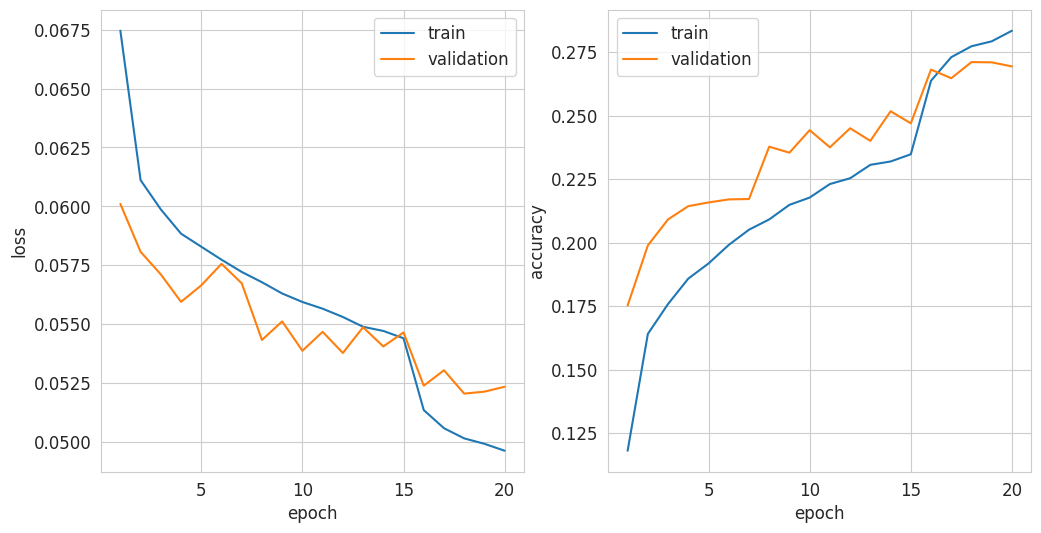

In [39]:
#!g1.1

train_transform = T.Compose([
    T.Resize(80),
    T.CenterCrop(40),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean=[0.5692, 0.5447, 0.4933], std=[0.2378, 0.2327, 0.2507]),
])
train_data.transform = train_transform

train, val = split_data(train_data)
train_loader = DataLoader(train, batch_size=64, shuffle=True)
val_loader = DataLoader(val, batch_size=64, shuffle=True)

num_epochs = 20
train_losses, test_losses, train_accuracies, test_accuracies = train_model(
    model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs, debug=True
)

In [40]:
#!g1.1

save_state(model, optimizer, 'finetuningmodel.pth.tar')

Ура, ура! Модель теперь не так ужасно переобучается! Но нужно большее качество, попробуем дообучить модель ещё на нескольких эпохах, но с другими аугментациями.

In [41]:
#!g1.1
#  отсюда
model = MyLittleNet(in_channels=3, basic_block=MyLittleResidualBlock, dropout=0.3)
model.linear = nn.Sequential(
    nn.BatchNorm1d(num_features=512),
    nn.Dropout(p=0.25),
    nn.Linear(in_features=512, out_features=512),
    nn.ReLU(),
    nn.BatchNorm1d(num_features=512, eps=1e-05, momentum=0.1),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=512, out_features=200),
)
load_state(model, None, filename='finetuningmodel.pth.tar')
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
# досюда коммент
optimizer = torch.optim.SGD(model.parameters(), lr=0.25, momentum=0.9)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15], gamma=0.3)

<ipython-input-14-b9bb4043d9ce>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(filename)


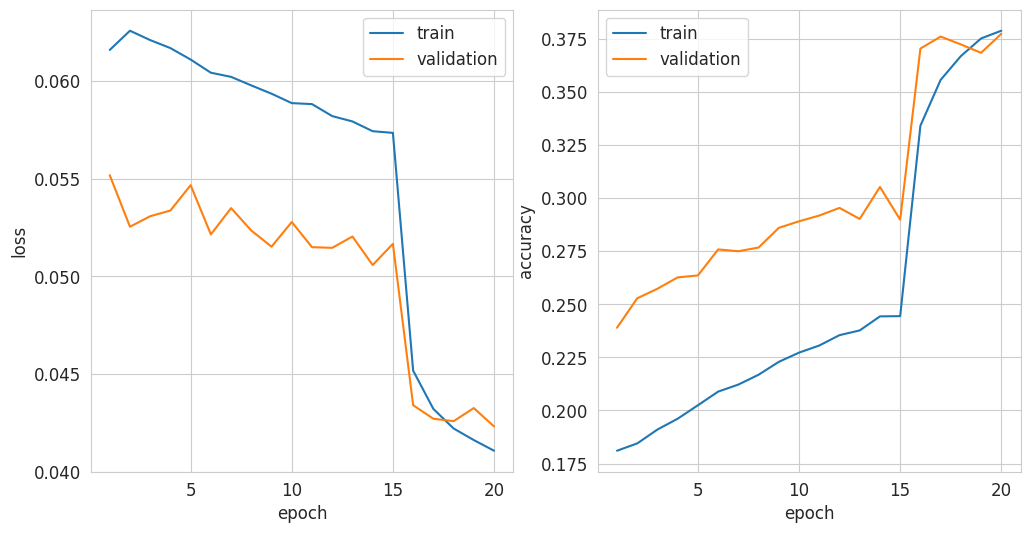

In [42]:
#!g1.1

train_transform = T.Compose([
    T.RandomAutocontrast(),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean=[0.5692, 0.5447, 0.4933], std=[0.2378, 0.2327, 0.2507]),
])
train_data.transform = train_transform

train, val = split_data(train_data)
train_loader = DataLoader(train, batch_size=64, shuffle=True)
val_loader = DataLoader(val, batch_size=64, shuffle=True)

num_epochs = 20
train_losses, test_losses, train_accuracies, test_accuracies = train_model(
    model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs, debug=True
)

In [43]:
#!g1.1

save_state(model, optimizer, 'newaugfinetuningmodel.pth.tar')

В целом выглядит неплохо! Продолжим обучение ещё в 5 эпох.

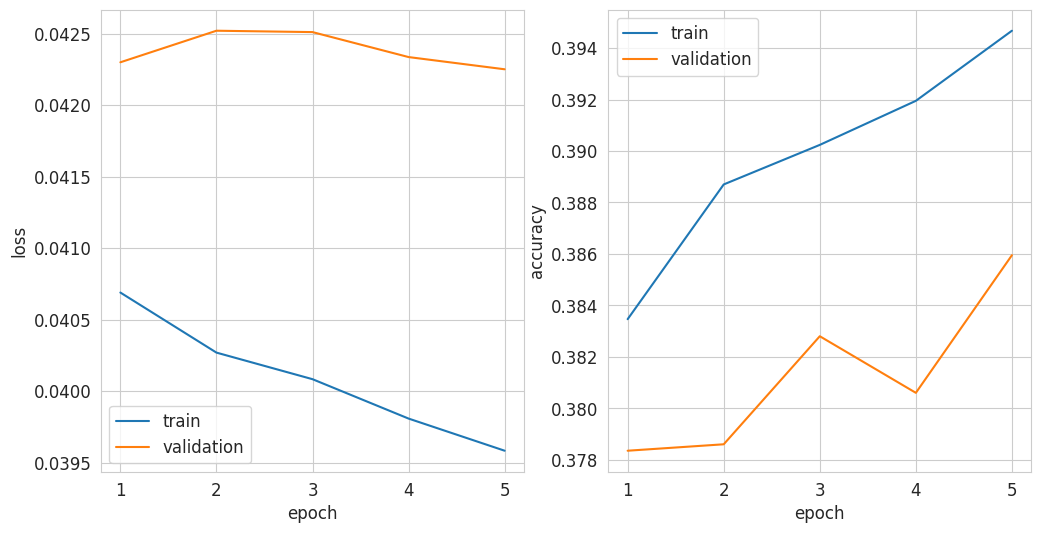

In [44]:
#!g1.1
num_epochs = 5
train_losses, test_losses, train_accuracies, test_accuracies = train_model(
    model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs, debug=True
)

In [45]:
#!g1.1

save_state(model, optimizer, 'newaugfinetuningmodel1.pth.tar')

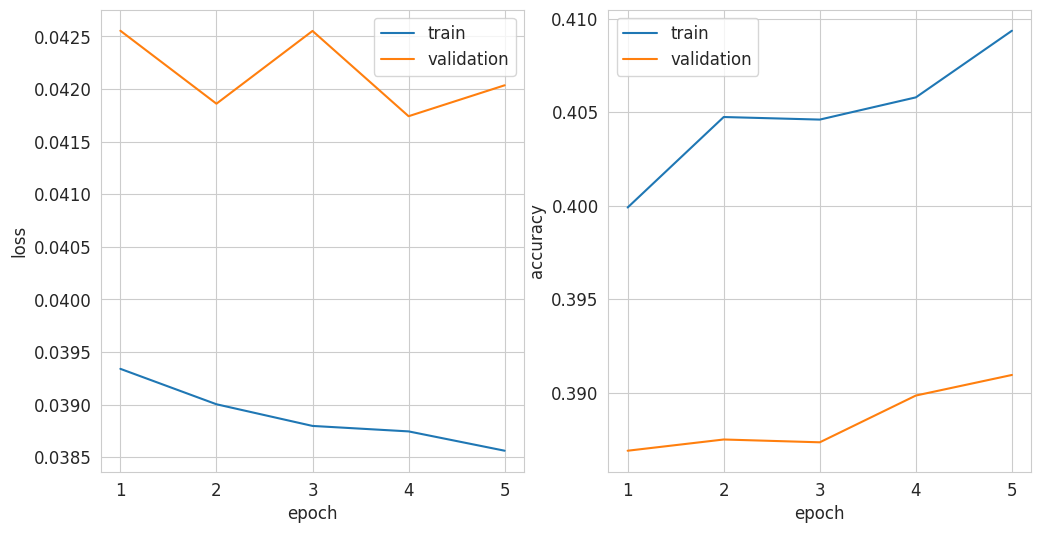

In [46]:
#!g1.1

num_epochs = 5
train_losses, test_losses, train_accuracies, test_accuracies = train_model(
    model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs, debug=True
)

Видно, что модель снова начала переобучаться. Попробуем начать обучать её на новых аугментациях. Очень интересно посмотреть на то, как будет обучатся модель на `AutoAugment`.

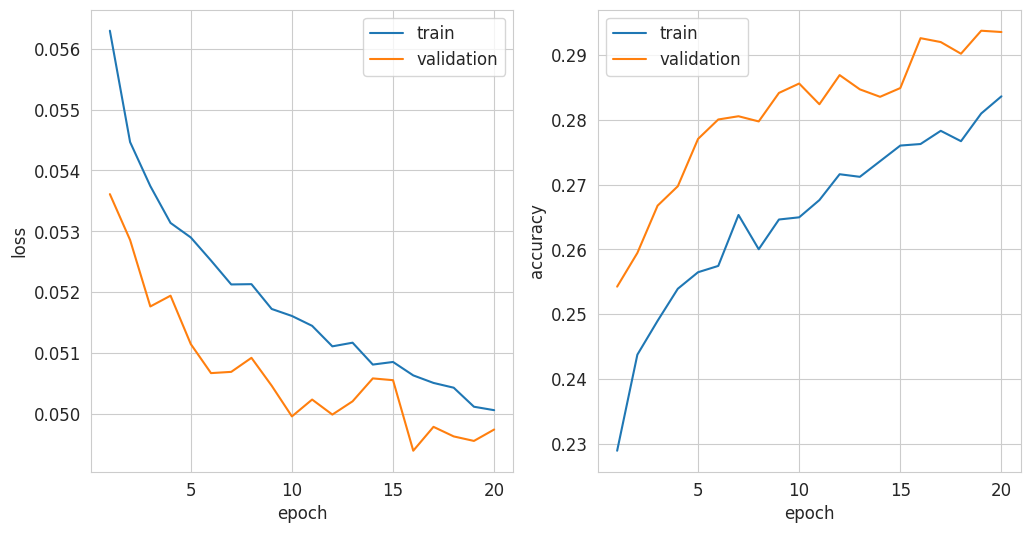

In [47]:
#!g1.1

train_transform = T.Compose([
    T.AutoAugment(),
    T.ToTensor(),
])
train_data.transform = train_transform

train, val = split_data(train_data)
train_loader = DataLoader(train, batch_size=64, shuffle=True)
val_loader = DataLoader(val, batch_size=64, shuffle=True)

num_epochs = 20
train_losses, test_losses, train_accuracies, test_accuracies = train_model(
    model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs, debug=True
)

In [48]:
#!g1.1

save_state(model, optimizer, 'autoaugfinetuningmodel2.pth.tar')

Модель не переобучается, обучим ещё 20 эпох.

In [49]:
#!g1.1
# отсюда
model = MyLittleNet(in_channels=3, basic_block=MyLittleResidualBlock, dropout=0.3)
model.linear = nn.Sequential(
    nn.BatchNorm1d(num_features=512),
    nn.Dropout(p=0.25),
    nn.Linear(in_features=512, out_features=512),
    nn.ReLU(),
    nn.BatchNorm1d(num_features=512, eps=1e-05, momentum=0.1),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=512, out_features=200),
)
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.25, momentum=0.9)
load_state(model, optimizer, filename='autoaugfinetuningmodel2.pth.tar')

criterion = torch.nn.CrossEntropyLoss()
# досюда коммент
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[7], gamma=0.3)

<ipython-input-14-b9bb4043d9ce>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(filename)


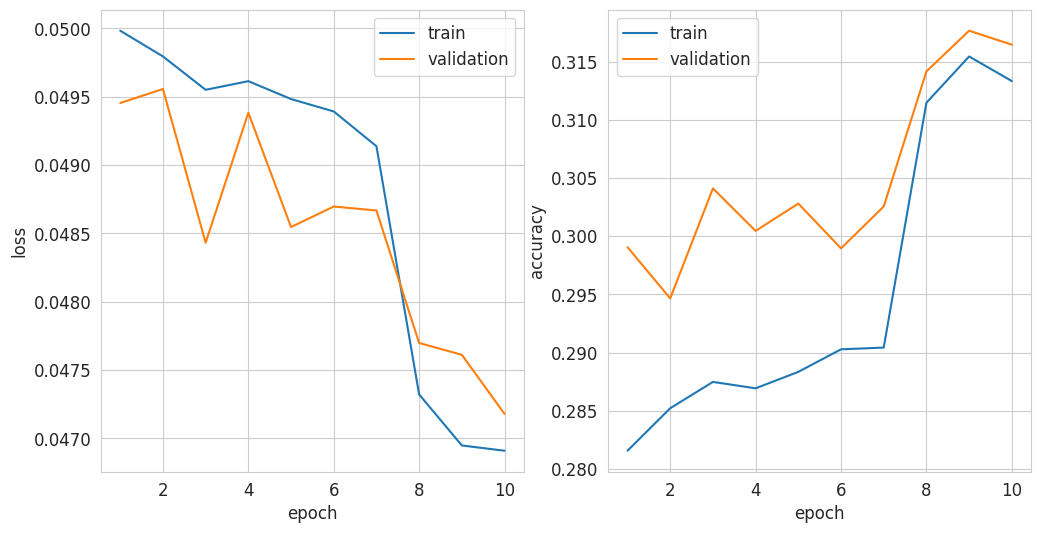

In [50]:
#!g1.1

train_transform = T.Compose([
    T.AutoAugment(),
    T.ToTensor(),
])
train_data.transform = train_transform

train, val = split_data(train_data)
train_loader = DataLoader(train, batch_size=64, shuffle=True)
val_loader = DataLoader(val, batch_size=64, shuffle=True)

num_epochs = 10
train_losses, test_losses, train_accuracies, test_accuracies = train_model(
    model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs, debug=True
)

In [51]:
#!g1.1

save_state(model, optimizer, 'autoaugfinetuningmodel3.pth.tar')

In [52]:
#!g1.1
# отсюда
model = MyLittleNet(in_channels=3, basic_block=MyLittleResidualBlock, dropout=0.3)
model.linear = nn.Sequential(
    nn.BatchNorm1d(num_features=512),
    nn.Dropout(p=0.25),
    nn.Linear(in_features=512, out_features=512),
    nn.ReLU(),
    nn.BatchNorm1d(num_features=512, eps=1e-05, momentum=0.1),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=512, out_features=200),
)
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.25, momentum=0.9)
load_state(model, optimizer, filename='autoaugfinetuningmodel3.pth.tar')

criterion = torch.nn.CrossEntropyLoss()
# досюда
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[7], gamma=0.3)

<ipython-input-14-b9bb4043d9ce>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(filename)


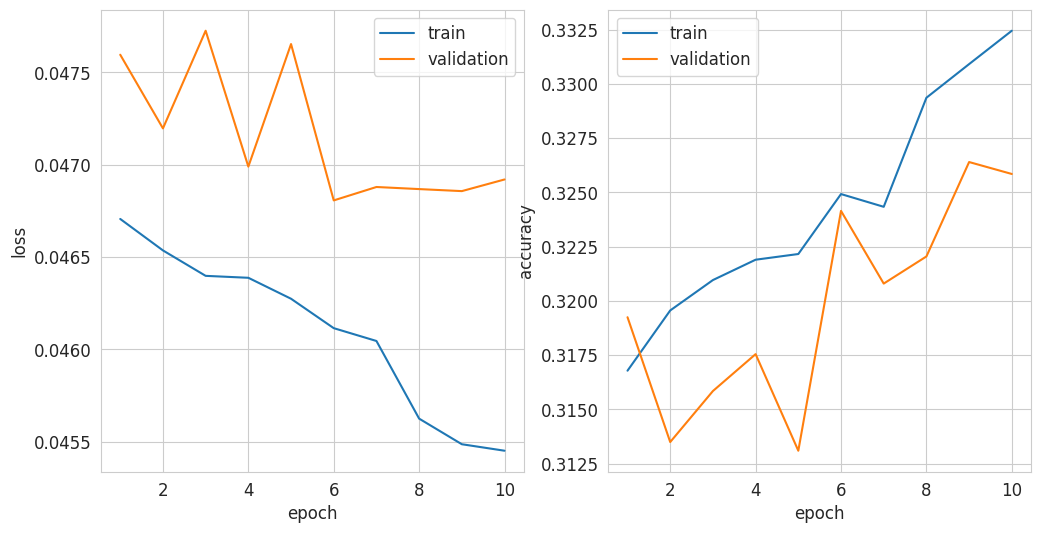

In [53]:
#!g1.1

train_transform = T.Compose([
    T.AutoAugment(),
    T.ToTensor(),
])
train_data.transform = train_transform

train, val = split_data(train_data)
train_loader = DataLoader(train, batch_size=64, shuffle=True)
val_loader = DataLoader(val, batch_size=64, shuffle=True)

num_epochs = 10
train_losses, test_losses, train_accuracies, test_accuracies = train_model(
    model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs, debug=True
)

In [54]:
#!g1.1

save_state(model, optimizer, 'autoaugfinetuningmodel4.pth.tar')

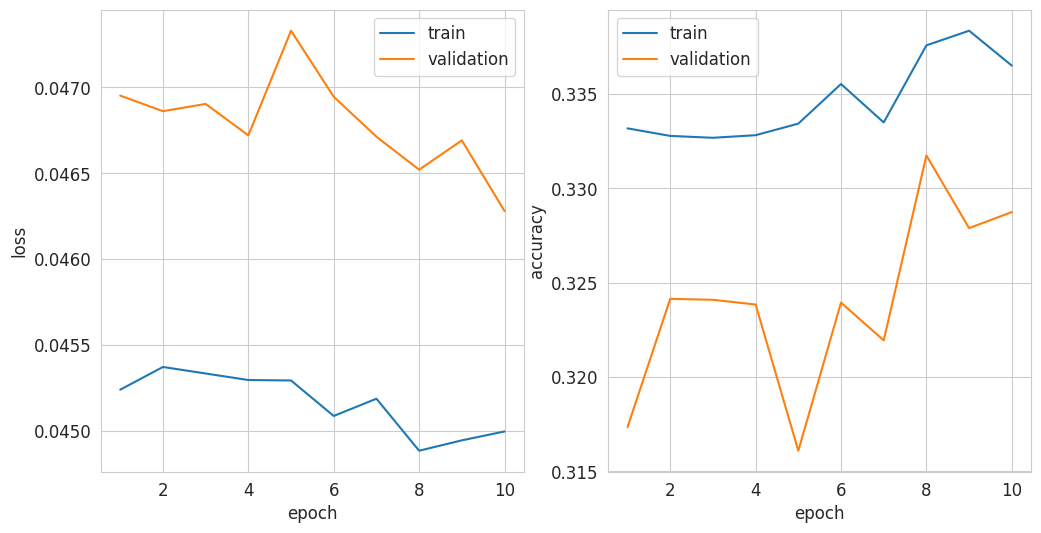

In [55]:
#!g1.1

criterion = torch.nn.CrossEntropyLoss() # коммент
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[7], gamma=0.3)

num_epochs = 10
train_losses, test_losses, train_accuracies, test_accuracies = train_model(
    model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs, debug=True
)

In [56]:
#!g1.1

save_state(model, optimizer, 'autoaugfinetuningmodel5.pth.tar')

In [57]:
#!g1.1
# отсюда
model = MyLittleNet(in_channels=3, basic_block=MyLittleResidualBlock, dropout=0.3)
model.linear = nn.Sequential(
    nn.BatchNorm1d(num_features=512),
    nn.Dropout(p=0.25),
    nn.Linear(in_features=512, out_features=512),
    nn.ReLU(),
    nn.BatchNorm1d(num_features=512, eps=1e-05, momentum=0.1),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=512, out_features=200),
)
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.25, momentum=0.9)
load_state(model, optimizer, filename='autoaugfinetuningmodel5.pth.tar')

criterion = torch.nn.CrossEntropyLoss()
# досюда
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[7], gamma=0.3)

<ipython-input-14-b9bb4043d9ce>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(filename)


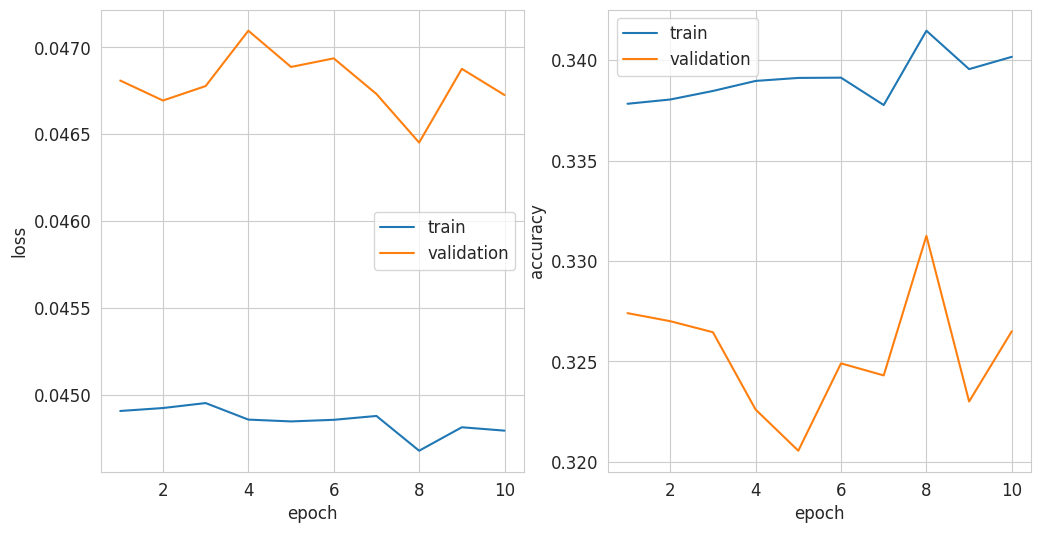

In [58]:
#!g1.1

train_transform = T.Compose([
    T.AutoAugment(),
    T.ToTensor(),
])
train_data.transform = train_transform

train, val = split_data(train_data)
train_loader = DataLoader(train, batch_size=64, shuffle=True)
val_loader = DataLoader(val, batch_size=64, shuffle=True)

num_epochs = 10
train_losses, test_losses, train_accuracies, test_accuracies = train_model(
    model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs, debug=True
)

In [59]:
#!g1.1

save_state(model, optimizer, 'autoaugfinetuningmodel6.pth.tar')

Доучим модель, обученую на автоаугментациях, на своих аугментациях, так как на афтоаугментациях она стала очень медленно учится и не давала прогресса.

In [60]:
#!g1.1
#отсюда
model = MyLittleNet(in_channels=3, basic_block=MyLittleResidualBlock, dropout=0.3)
model.linear = nn.Sequential(
    nn.BatchNorm1d(num_features=512),
    nn.Dropout(p=0.25),
    nn.Linear(in_features=512, out_features=512),
    nn.ReLU(),
    nn.BatchNorm1d(num_features=512, eps=1e-05, momentum=0.1),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=512, out_features=200),
)
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.25, momentum=0.9)
load_state(model, optimizer, filename='autoaugfinetuningmodel6.pth.tar')

criterion = torch.nn.CrossEntropyLoss()
# досюда
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[7], gamma=0.3)

<ipython-input-14-b9bb4043d9ce>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(filename)


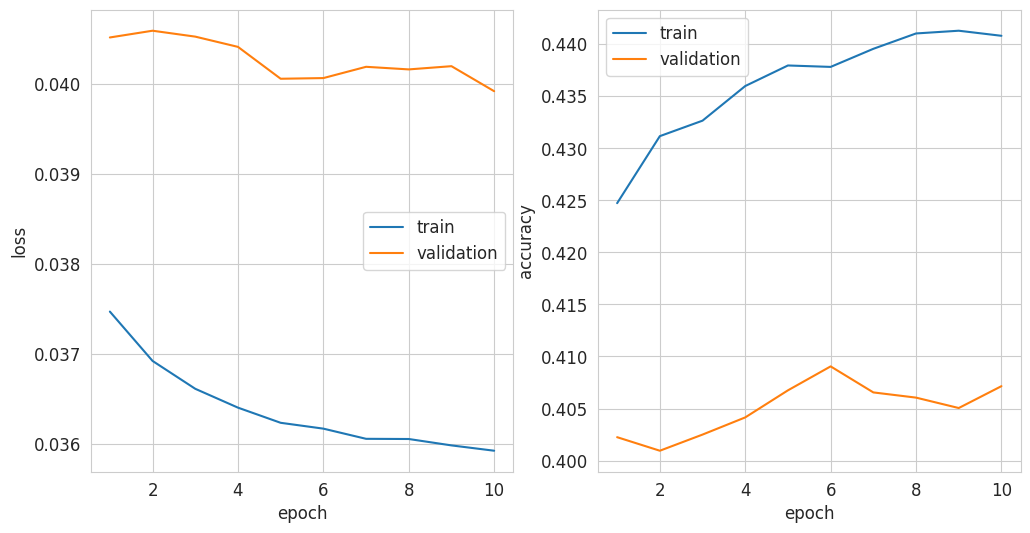

In [61]:
#!g1.1

train_transform = T.Compose([
    T.RandomAutocontrast(),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean=[0.5692, 0.5447, 0.4933], std=[0.2378, 0.2327, 0.2507]),
])
train_data.transform = train_transform

train, val = split_data(train_data)
train_loader = DataLoader(train, batch_size=64, shuffle=True)
val_loader = DataLoader(val, batch_size=64, shuffle=True)

num_epochs = 10
train_losses, test_losses, train_accuracies, test_accuracies = train_model(
    model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs, debug=True
)

In [62]:
#!g1.1

save_state(model, optimizer, 'afterautoaugfinetuning.pth.tar')

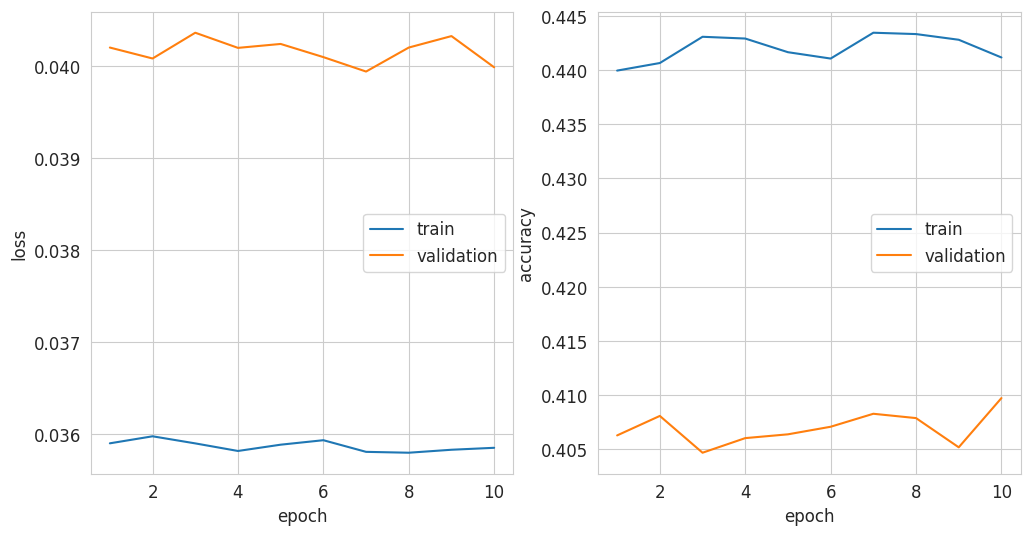

In [63]:
#!g1.1

train_transform = T.Compose([
    T.RandomAutocontrast(),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean=[0.5692, 0.5447, 0.4933], std=[0.2378, 0.2327, 0.2507]),
])
train_data.transform = train_transform

train, val = split_data(train_data)
train_loader = DataLoader(train, batch_size=64, shuffle=True)
val_loader = DataLoader(val, batch_size=64, shuffle=True)

criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[7], gamma=0.3)

num_epochs = 10
train_losses, test_losses, train_accuracies, test_accuracies = train_model(
    model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs, debug=True
)

In [64]:
#!g1.1

save_state(model, optimizer, 'afterautoaugfinetuning1.pth.tar')

In [65]:
#!g1.1
# отсюда
model = MyLittleNet(in_channels=3, basic_block=MyLittleResidualBlock, dropout=0.3)
model.linear = nn.Sequential(
    nn.BatchNorm1d(num_features=512),
    nn.Dropout(p=0.25),
    nn.Linear(in_features=512, out_features=512),
    nn.ReLU(),
    nn.BatchNorm1d(num_features=512, eps=1e-05, momentum=0.1),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=512, out_features=200),
)
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.25, momentum=0.9)
load_state(model, optimizer, filename='afterautoaugfinetuning1.pth.tar')

criterion = torch.nn.CrossEntropyLoss()
# досюда
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.1, step_size_up=5, mode="triangular")

<ipython-input-14-b9bb4043d9ce>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(filename)


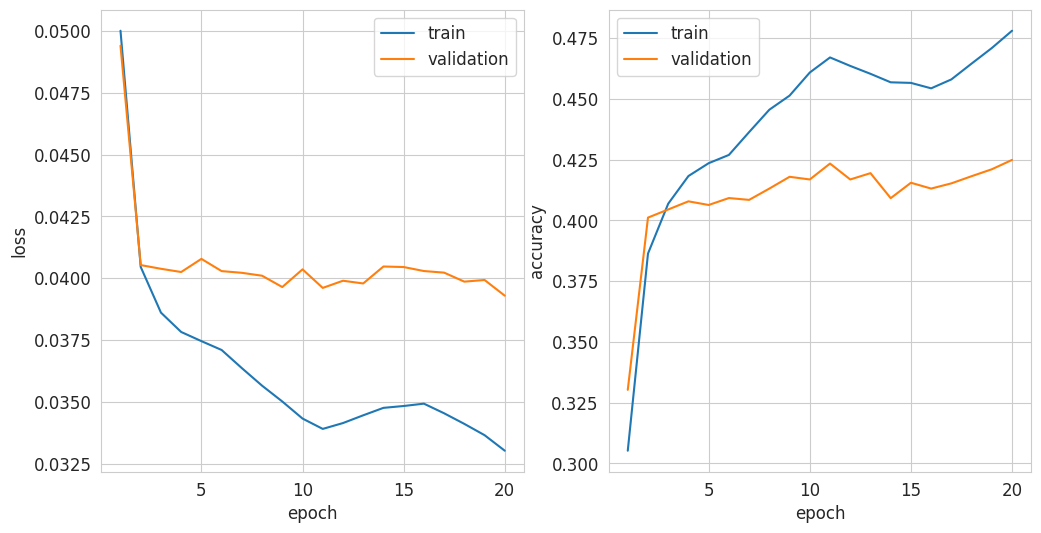

In [66]:
#!g1.1

train_transform = T.Compose([
    T.RandomAutocontrast(),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean=[0.5692, 0.5447, 0.4933], std=[0.2378, 0.2327, 0.2507]),
])
train_data.transform = train_transform

train, val = split_data(train_data)
train_loader = DataLoader(train, batch_size=64, shuffle=True)
val_loader = DataLoader(val, batch_size=64, shuffle=True)

num_epochs = 20
train_losses, test_losses, train_accuracies, test_accuracies = train_model(
    model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs, debug=True
)

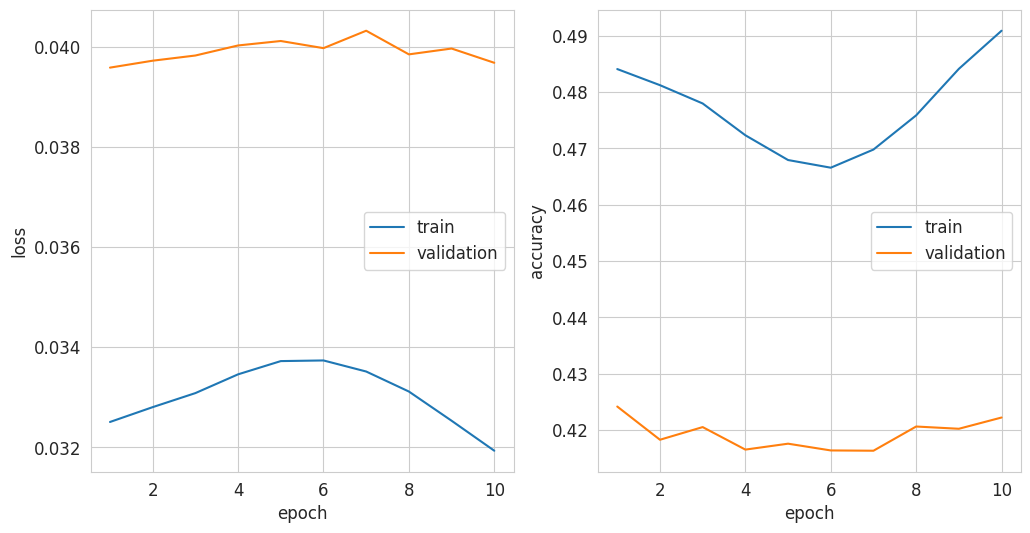

In [67]:
#!g1.1

num_epochs = 10
train_losses, test_losses, train_accuracies, test_accuracies = train_model(
    model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs, debug=True
)

In [ ]:
#!g1.1

save_state(model, optimizer, 'afterautoaugfinetuning5.pth.tar')
state = {
    'scheduler_dict': scheduler.state_dict()
}
torch.save(state, 'scheduler1.pth.tar')

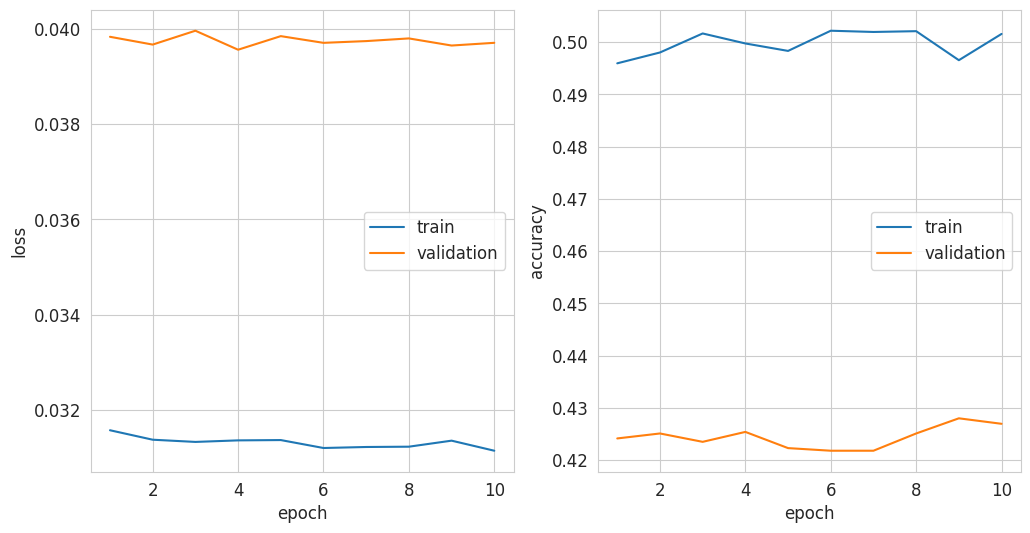

In [69]:
#!g1.1

num_epochs = 10
train_losses, test_losses, train_accuracies, test_accuracies = train_model(
    model, optimizer, None, criterion, train_loader, val_loader, num_epochs, debug=True
)

In [ ]:
#!g1.1

save_state(model, optimizer, 'afterautoaugfinetuning6.pth.tar')
state = {
    'scheduler_dict': scheduler.state_dict()
}
torch.save(state, 'scheduler2.pth.tar')

In [ ]:
test_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.5692, 0.5447, 0.4933], std=[0.2378, 0.2327, 0.2507]),
])
test_data.transform = test_transform

test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

prediction = predict(test_loader, model)
prediction.to_csv('labels_test.csv', index=False)

In [72]:
print('все')

все
все


In [73]:
test_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.5692, 0.5447, 0.4933], std=[0.2378, 0.2327, 0.2507]),
])
test_data.transform = test_transform

test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

prediction = predict(test_loader, model)
prediction.to_csv('labels_test.csv', index=False)